# Introduction
This notebook summarizes an evaluation of a potential rental property using monte carlo simulation as well as some basic modelling techniques.
The purpose of this project is to have some fun exploring a fictional investment property.

I was recently reviewing a brochure for an investment opportunity in Alabama.  The rent was set at fixed number. We will make assumptions about the purchase price and interest rates to evaluate the opportunity.


In [1]:
library(dplyr)
library(tidyquant)
library(ggplot2)
library(quantmod)
library(dplyr)
library(ggplot2)
library(xts)


options(scipen = 999)




Warning message:
"package 'dplyr' was built under R version 3.6.2"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'tidyquant' was built under R version 3.6.2"Loading required package: lubridate

Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date

Loading required package: PerformanceAnalytics
Warning message:
"package 'PerformanceAnalytics' was built under R version 3.6.2"Loading required package: xts
Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 

Attaching package: 'xts'

The following objects are masked from 'package:dplyr':

    first, last


Attaching package: 'PerformanceAnalytics'

The followi

# Specify Variables
The flyer mentioned a rent of 1450. I'll assume home price base on the 1% rule.

In [2]:
# Specify variable
rent<-1450
purchase_price<- rent/.0075
monthly_rate = 6.04 / 100 / 12
down_payment  <- .3*purchase_price
loan_amount =  purchase_price-down_payment
expenses_rate<-.02

#  a / {[(1+r)^n]-1]} / [r(1+r)^n] = p
# Note: a = total loan amount, r = periodic interest rate, n = total number of payment periods, p = monthly payment).

rate = (1 + monthly_rate) ^ 360 - 1
m_payment = loan_amount * monthly_rate * (rate + 1) / rate
m_mort_taxes <-(.02/12)*purchase_price
m_mort_ins <- 160
mortgage_payment=(m_payment+m_mort_taxes+m_mort_ins)*-1

# Annual rental yield allowing for management fee
gross_rental_yield=  (12 * (rent*.9))/purchase_price

# Key outputs
print(paste('buy property: ' ,'$', purchase_price, sep='' ))
print(paste('Downpayment: '  ,'$', down_payment, sep=''  ))
print(paste('Monthly Payment: '  ,'$', mortgage_payment, sep=''  ))
print(paste('Rental Yield: '  , '%',gross_rental_yield*100, sep=''  ))


[1] "buy property: $193333.333333333"
[1] "Downpayment: $58000"
[1] "Monthly Payment: $-1297.09753811398"
[1] "Rental Yield: %8.1"


In [18]:
mortgage_payment

[1] -1297.098

# Pull Treasury Data

In [3]:
library(dplyr)
library(zoo)

yield_10y <- getSymbols(Symbols = "DGS10", src = "FRED", auto.assign = FALSE)
yield_10y_monthly <- yield_10y[endpoints(yield_10y, on = "months", k = 1)]
yield_10y_monthly <- yield_10y_monthly["2002-01-01/2023-01-01"]

#interpolate missing values in yield column
yield_10y_monthly= data.frame(date=index(yield_10y_monthly), coredata(yield_10y_monthly)) %>% 
        mutate(DGS10 = na.approx(DGS10))


head(yield_10y_monthly)



'getSymbols' currently uses auto.assign=TRUE by default, but will
use auto.assign=FALSE in 0.5-0. You will still be able to use
'loadSymbols' to automatically load data. getOption("getSymbols.env")
and getOption("getSymbols.auto.assign") will still be checked for
alternate defaults.

This message is shown once per session and may be disabled by setting 
options("getSymbols.warning4.0"=FALSE). See ?getSymbols for details.



date,DGS10
2002-01-31,5.070
2002-02-28,4.880
2002-03-29,4.995
2002-04-30,5.110
2002-05-31,5.080
2002-06-28,4.860


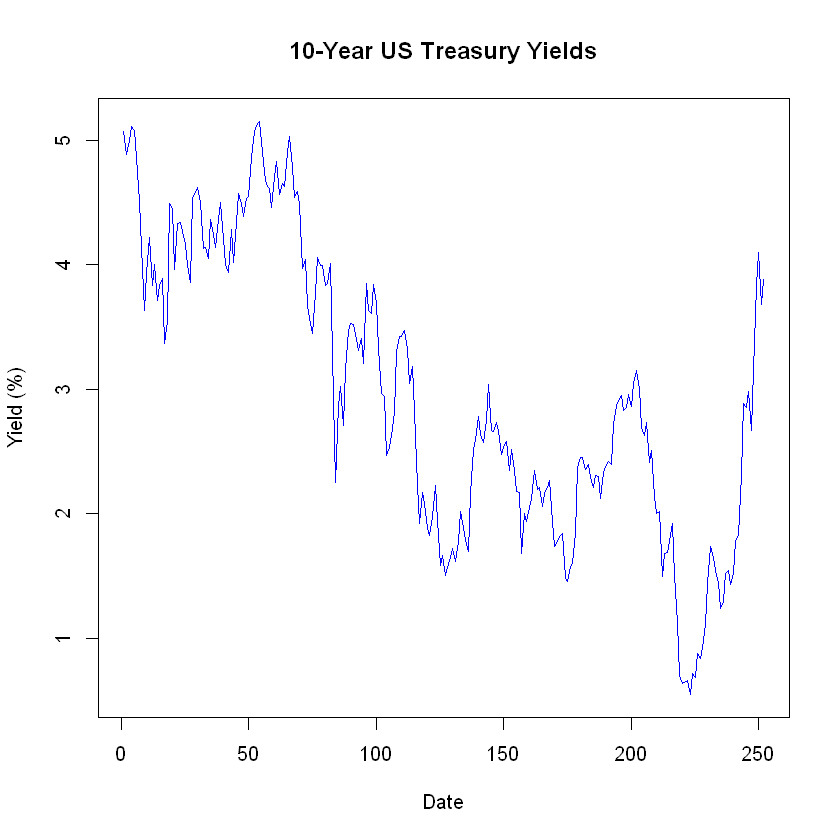

In [4]:
# Plot yields
 plot(x = index(yield_10y_monthly),
     y = yield_10y_monthly$DGS10,
     xlab = "Date",
     ylab = "Yield (%)",
     type = "l",
     col = "blue",
     main = "10-Year US Treasury Yields")

In [5]:
#10 yr yields vs rental opportunity

ten_year= tail(yield_10y_monthly,n=1)
risk_free_rate = ten_year[,2]

# compare gross rental yield to risk free rate
ratio= round(((gross_rental_yield*100)/risk_free_rate),2)
print(paste('The gross rental yield is ', ratio, 'times the risk free rate', '(',risk_free_rate,')'))


[1] "The gross rental yield is  2.09 times the risk free rate ( 3.88 )"


In [6]:
mortgage_payment
m_mort_ins

[1] -1297.098

[1] 160

In [7]:
# calculate NOI
# excludes mortgage payments
# assumes 10% management fee
noi= (12 * rent)*.9
noi

# cap rate
# noi divided by property value

cap_rate=noi/purchase_price
cap_rate

net_profit=   rent*.9+ (mortgage_payment )
((net_profit*12)/down_payment)*100

years=seq(0,30,1)

time_series=tibble(years)

sale_price= (purchase_price*1.02^30)


[1] 15660

[1] 0.081

[1] 0.1634992

In [8]:
cash=(1450+(mortgage_payment*.9))*12
cash/down_payment

[1] 0.05847149

In [9]:
gross_rental_yield

[1] 0.081

## cashflow time series

In [10]:
cashflow=time_series %>% 
  dplyr::mutate(home_value= if_else(years==0, purchase_price,purchase_price*1.02^years)) %>% 
  dplyr::mutate(investment= if_else(years==0, -down_payment,-rent*.1)) %>% 
  dplyr::mutate(payment  = (mortgage_payment *12)) %>% 
  dplyr::mutate(rent  =  (rent*1.03^years     )*12) %>% 
  dplyr::mutate(cashflow  = rent+payment+investment  ) %>% 
  dplyr::mutate(cashflow=   if_else(years==30, rent+payment+investment+sale_price,rent+payment+investment))

#calculate final sale price at 30 years
cf=as.vector(cashflow[['cashflow']])

IRR(cf)


head(cashflow)

[1] 0.1340702

years,home_value,investment,payment,rent,cashflow
0,193333.3,-58000,-15565.17,17400.00,-56165.170
1,197200.0,-145,-15565.17,17922.00,2211.830
2,201144.0,-145,-15565.17,18459.66,2749.490
3,205166.9,-145,-15565.17,19013.45,3303.279
4,209270.2,-145,-15565.17,19583.85,3873.683
5,213455.6,-145,-15565.17,20171.37,4461.198


# Monte Carlo Simulations

Stochastic simulation sampling from a normal distribution.


In [11]:
start_t=10
mu=.04

############
## Model Stochastic Volatility Process

set.seed(1985)
run_count=300
 
# start_price= matrix(purchase_price, ncol = 1, nrow = 30)
# colnames(start_price)<-paste("home_price")
 shock_1 <- matrix(NA, ncol = run_count, nrow = 30)
# shock_1 <-cbind(start_price,shock_1 )
 for (i in 1:ncol(shock_1)) {
  shock_1[,i] <- rnorm(30, mean = .025, sd = .05)
 } 


vol_matrix <- matrix(0, ncol = run_count, nrow = 30)
colnames(vol_matrix) <- paste("Sim", 1:ncol(vol_matrix))
rownames(vol_matrix) <- paste("Year", 1:30)


#vol_null <- vol^2
for (j in 1:ncol(vol_matrix)) {
  #put purchase price as first row of home price simulations
  vol_matrix[1,j] <- purchase_price
  
  for (i in 2:nrow(vol_matrix)) {
    vol_matrix[i,j] <- (shock_1[i,j] )
  }
  # apply percent to pricing
  for (i in 2:nrow(vol_matrix)) {
    vol_matrix[i,j] <-  vol_matrix[(i-1),j] *(1+shock_1[i,j])
  }
  
}

In [12]:
head(vol_matrix,3)

,Sim 1,Sim 2,Sim 3,Sim 4,Sim 5,Sim 6,Sim 7,Sim 8,Sim 9,Sim 10,...,Sim 291,Sim 292,Sim 293,Sim 294,Sim 295,Sim 296,Sim 297,Sim 298,Sim 299,Sim 300
Year 1,193333.3,193333.3,193333.3,193333.3,193333.3,193333.3,193333.3,193333.3,193333.3,193333.3,...,193333.3,193333.3,193333.3,193333.3,193333.3,193333.3,193333.3,193333.3,193333.3,193333.3
Year 2,187407.3,208160.8,190394.8,193247.4,200569.4,201254.0,177353.6,188113.1,195903.8,178097.0,...,203093.7,189493.4,199283.6,204501.6,206698.3,214957.5,205437.5,200898.4,198307.2,203467.5
Year 3,189131.8,216034.7,214792.7,209336.4,204010.3,212264.3,192946.6,188338.1,191900.3,175919.0,...,198888.7,192174.4,219915.5,200231.9,208629.7,209735.3,212761.8,197450.6,198037.4,200933.2


In [24]:
home_sim_prices = vol_matrix %>% 
  as_tibble(.) %>% 
  tidyr::pivot_longer(.,cols=1:(ncol(vol_matrix)), names_to='case_name', values_to='home_price') %>% 
  dplyr::group_by(case_name) %>% 
  dplyr::mutate(year=row_number()) %>% 
  dplyr::ungroup() %>% 
  dplyr::arrange(case_name, year) %>% 
  dplyr::mutate(proceeds= ifelse(year==30,home_price*.7,0)) %>% 
  dplyr::mutate(y_rental_income= 12*(.007*home_price)) %>% 
  dplyr::mutate(y_principal= m_payment*12) %>% 
  dplyr::mutate(y_mortgage_taxes_insurance= -( m_mort_taxes  + m_mort_ins)*12) %>% 
  dplyr::mutate(y_net_rental_income= (y_rental_income*.9)+y_mortgage_taxes_insurance     ) %>% 
  dplyr::mutate(expenses= if_else(year==1, -down_payment, -.1*y_rental_income)) %>% 
  dplyr::mutate(net_cashflow= y_rental_income+y_mortgage_taxes_insurance+expenses+proceeds) %>% 
  dplyr::group_by(case_name) %>% 
  dplyr::mutate(cum_cashflow= cumsum(net_cashflow-proceeds) ) %>% 
  dplyr::ungroup()
head(home_sim_prices)

case_name,home_price,year,proceeds,y_rental_income,y_principal,y_mortgage_taxes_insurance,y_net_rental_income,expenses,net_cashflow,cum_cashflow
Sim 1,193333.3,1,0,16240.00,9778.504,-5786.667,8829.333,-58000.000,-47546.667,-47546.667
Sim 1,187407.3,2,0,15742.21,9778.504,-5786.667,8381.326,-1574.221,8381.326,-39165.341
Sim 1,189131.8,3,0,15887.07,9778.504,-5786.667,8511.698,-1588.707,8511.698,-30653.643
Sim 1,195210.3,4,0,16397.66,9778.504,-5786.667,8971.231,-1639.766,8971.231,-21682.412
Sim 1,212265.7,5,0,17830.32,9778.504,-5786.667,10260.619,-1783.032,10260.619,-11421.793
Sim 1,212000.3,6,0,17808.03,9778.504,-5786.667,10240.558,-1780.803,10240.558,-1181.235


In [26]:
# calculate median value for all simulation
home_sim_prices_summary=home_sim_prices %>% 
  dplyr::group_by(year) %>% 
  dplyr::summarise(mdn_home_price=median(home_price), mdn_cashflow=median(net_cashflow)) %>% 
  dplyr::ungroup() %>% 
  dplyr::mutate(case_name='median')

# calculate key economic indicators
irr_investment= home_sim_prices %>% 
  dplyr::select(., case_name,year, net_cashflow,cum_cashflow) %>% 
  dplyr::filter(year <=30) %>% 
  dplyr::group_by(case_name) %>% 
  dplyr::mutate(irr=tidyquant::IRR(net_cashflow)) %>% 
  dplyr::mutate(npv10=tidyquant::NPV(net_cashflow,.1)) %>% 
  dplyr::filter(year ==max(year)) %>% 
  dplyr::ungroup() 

summary(irr_investment$irr)
summary(irr_investment$npv10)
summary(irr_investment$cum_cashflow)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.1439  0.2133  0.2301  0.2288  0.2444  0.3008 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  22050   69799   84058   86565  101915  153343 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 148220  330770  385271  399224  464441  706868 

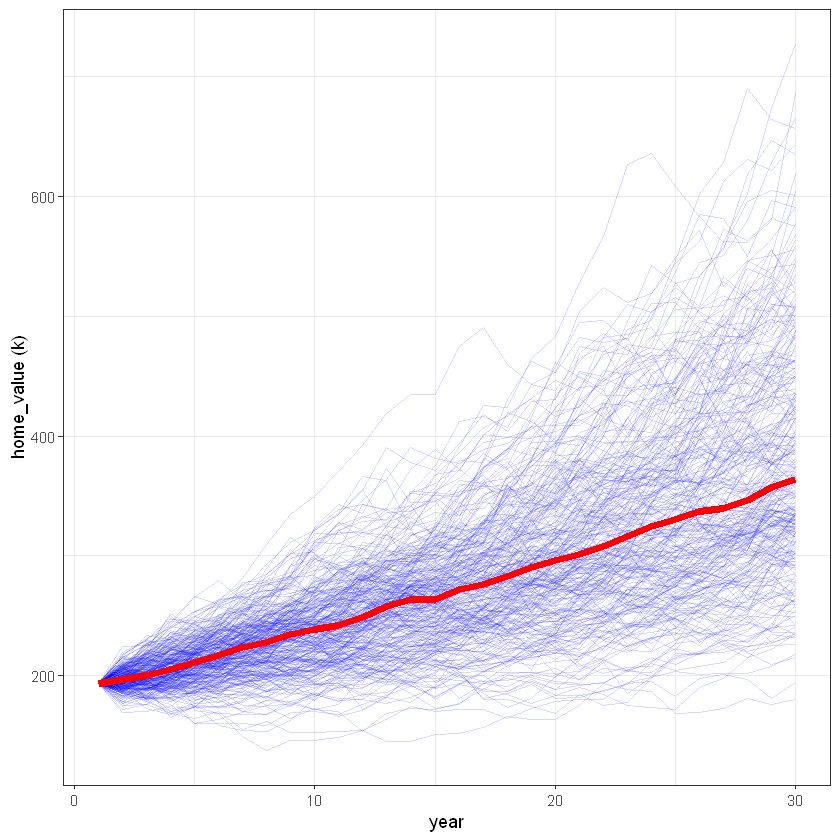

In [30]:
# plot of home price simulations
ggplot(home_sim_prices, aes(year,home_price/1000 , group=case_name))+
  geom_line(color='blue', alpha=.15)+
  labs(y='home_value (k)')+
  theme_bw()+
  geom_line(data=home_sim_prices_summary, aes(x=year,y=mdn_home_price/1000), color='red', size=2)

In [33]:
head(home_sim_prices)


case_name,home_price,year,proceeds,y_rental_income,y_principal,y_mortgage_taxes_insurance,y_net_rental_income,expenses,net_cashflow,cum_cashflow
Sim 1,193333.3,1,0,16240.00,9778.504,-5786.667,8829.333,-58000.000,-47546.667,-47546.667
Sim 1,187407.3,2,0,15742.21,9778.504,-5786.667,8381.326,-1574.221,8381.326,-39165.341
Sim 1,189131.8,3,0,15887.07,9778.504,-5786.667,8511.698,-1588.707,8511.698,-30653.643
Sim 1,195210.3,4,0,16397.66,9778.504,-5786.667,8971.231,-1639.766,8971.231,-21682.412
Sim 1,212265.7,5,0,17830.32,9778.504,-5786.667,10260.619,-1783.032,10260.619,-11421.793
Sim 1,212000.3,6,0,17808.03,9778.504,-5786.667,10240.558,-1780.803,10240.558,-1181.235


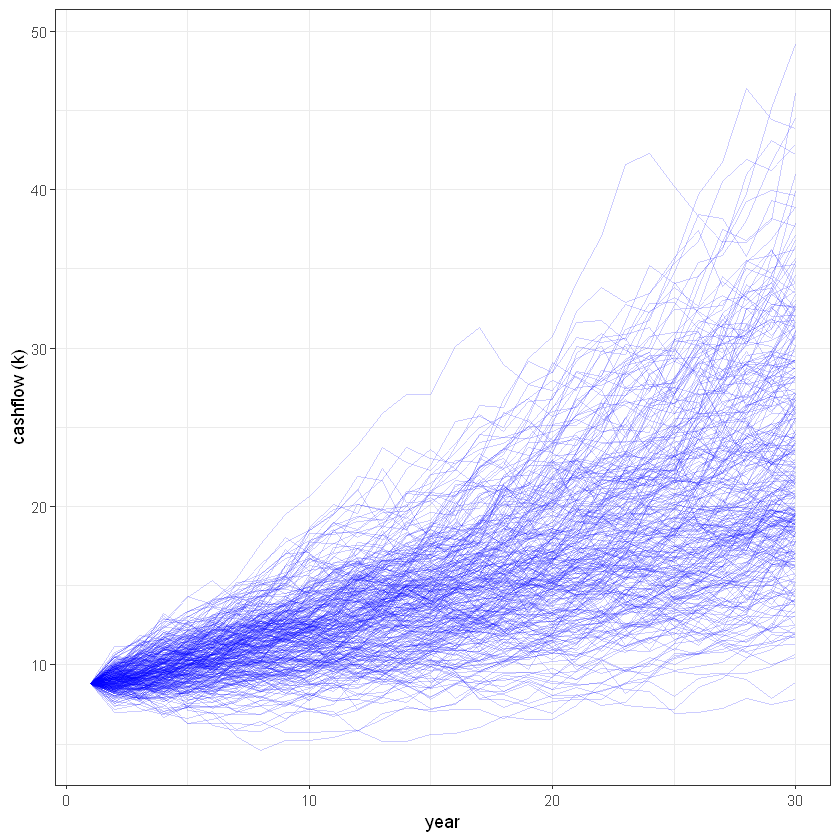

In [31]:
#annual cashflow
ggplot(home_sim_prices, aes(year,y_net_rental_income/1000 , group=case_name))+
  geom_line(color='blue', alpha=.2)+
  labs(y='cashflow (k)')+
  theme_bw()

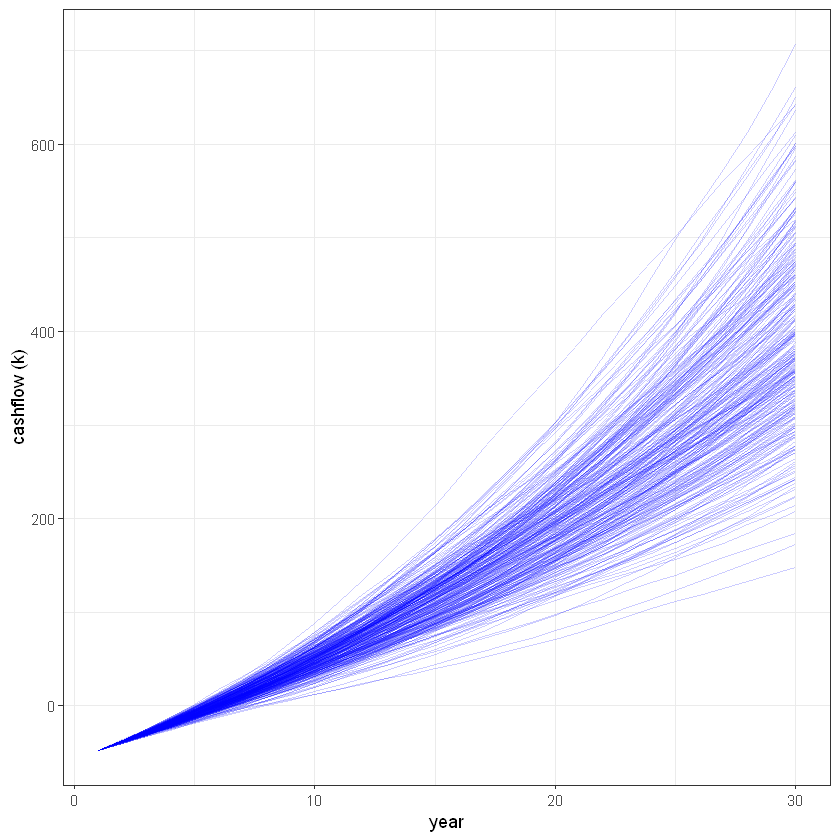

In [32]:
#annual cashflow
ggplot(home_sim_prices, aes(year,cum_cashflow/1000 , group=case_name))+
  geom_line(color='blue', alpha=.2)+
  labs(y='cashflow (k)')+
  theme_bw()